In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../')
from hipparchus import EchelleSpectrum, Template, cross_corr

Import the echelle spectrum from the `e2ds` file: 

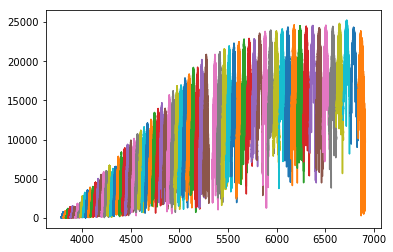

In [2]:
from glob import glob

paths = glob('/Users/bmmorris/data/harps/sun/*.fits')
spectra = []
for path in paths: 
    spectrum = EchelleSpectrum.from_e2ds(path)
    spectra.append(spectrum)
spectrum.plot()

Continuum normalize each echelle order: 

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


(0, 1.5)

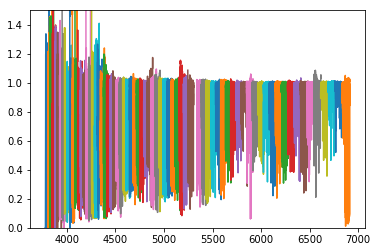

In [3]:
for spectrum in spectra: 
    spectrum.continuum_normalize()

spectrum.plot()
plt.ylim([0, 1.5])

Load a template for TiO at 4000 K, generated by Daniel Kitzmann: 

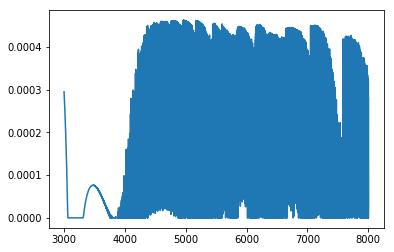

In [4]:
template_tio_3000 = Template.from_npy('../kitzmann/emission_spectrum_3000K_tio.npy')
template_tio_4000 = Template.from_npy('../kitzmann/emission_spectrum_4000K_tio.npy')

template_tio_3000.plot()

Cross-correlate the spectrum against the template: 

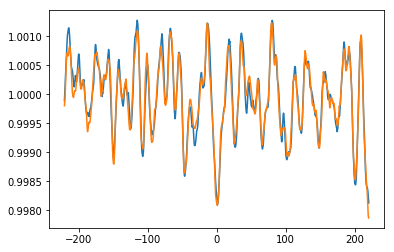

In [6]:
wavelength_0 = 6725
wavelength_1 = 6800

ccfs = []
for spectrum in spectra: 
    ccf_1 = cross_corr(spectrum.nearest_order(wavelength_1), template_tio_4000, start_lam=-5, end_lam=5)
    ccf_1.plot()
    ccfs.append(ccf_1)

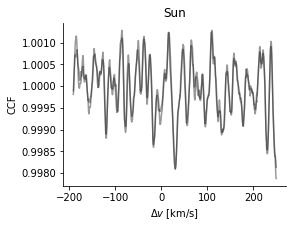

In [9]:
import astropy.units as u

plt.figure(figsize=(4, 3))
for ccf in ccfs: 
    plt.plot(ccf.velocities + ccf.header['HIERARCH ESO DRS BERV'] * u.km/u.s, ccf.ccf/np.median(ccf.ccf), color='k', alpha=0.4)
plt.xlabel('$\Delta v$ [km/s]')
plt.ylabel('CCF')
plt.title('Sun')
# plt.axvline(0, ls=':', color='gray')
for s in ['right', 'top']: 
    plt.gca().spines[s].set_visible(False)
plt.savefig('plots/sun.pdf', bbox_inches='tight')

In [10]:
ccf.header['DATE-OBS']

'2015-11-02T08:01:44.869'

In [60]:
import drms
from astropy.io import fits

c = drms.Client()

# Use drms to search for an SDO HMI continuum intensity image closest to the time below.
# We query the FITS header keywords and the data arrays, or segments, separately:
keys, segments = c.query('hmi.Ic_45s[{0}]'.format('2015.11.02'), #day.strftime("%Y.%m.%d")), 
                         key=drms.const.all, seg='continuum')

# Download the file(s)
url = 'http://jsoc.stanford.edu' + segments.continuum[0]
image = fits.getdata(url)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/drms/client.py:1089: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res_key = pd.DataFrame.from_items(zip(names, values))
/Users/bmmorris/anaconda/lib/python3.5/site-packages/drms/client.py:1100: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res_seg = pd.DataFrame.from_items(zip(names, values))


In [71]:
from sunpy.map import Map

m = Map(url)

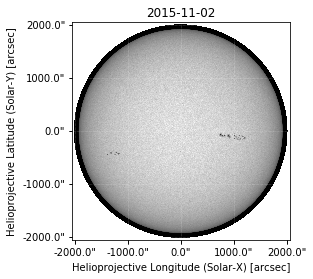

In [75]:
m.plot()
plt.gca().set_title('2015-11-02')
plt.savefig('plots/sun_hmi.pdf', bbox_inches='tight', dpi=300)